# Project 4 Notebook For Udacity Self Driving Car Course

______________________________________________________________________________________________________________________

# Part 1: Compute the camera calibration using chessboard images

Step 0: Import necessary packages and libraries

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

Step 1: Read in the test image

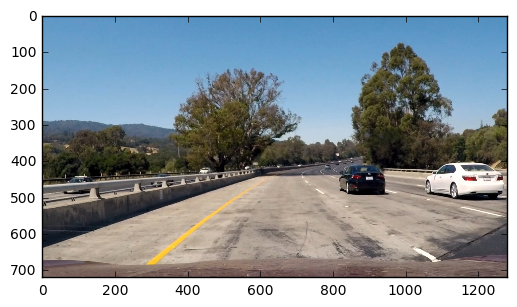

In [2]:
# Read in an image
# ex_img = cv2.imread('camera_cal/calibration12.jpg')
example_img = mpimg.imread('test_images/test1.jpg')
test_ex_img = example_img.copy()
plt.imshow(test_ex_img)

Step 2: Calibrate the camera and undistort the test image

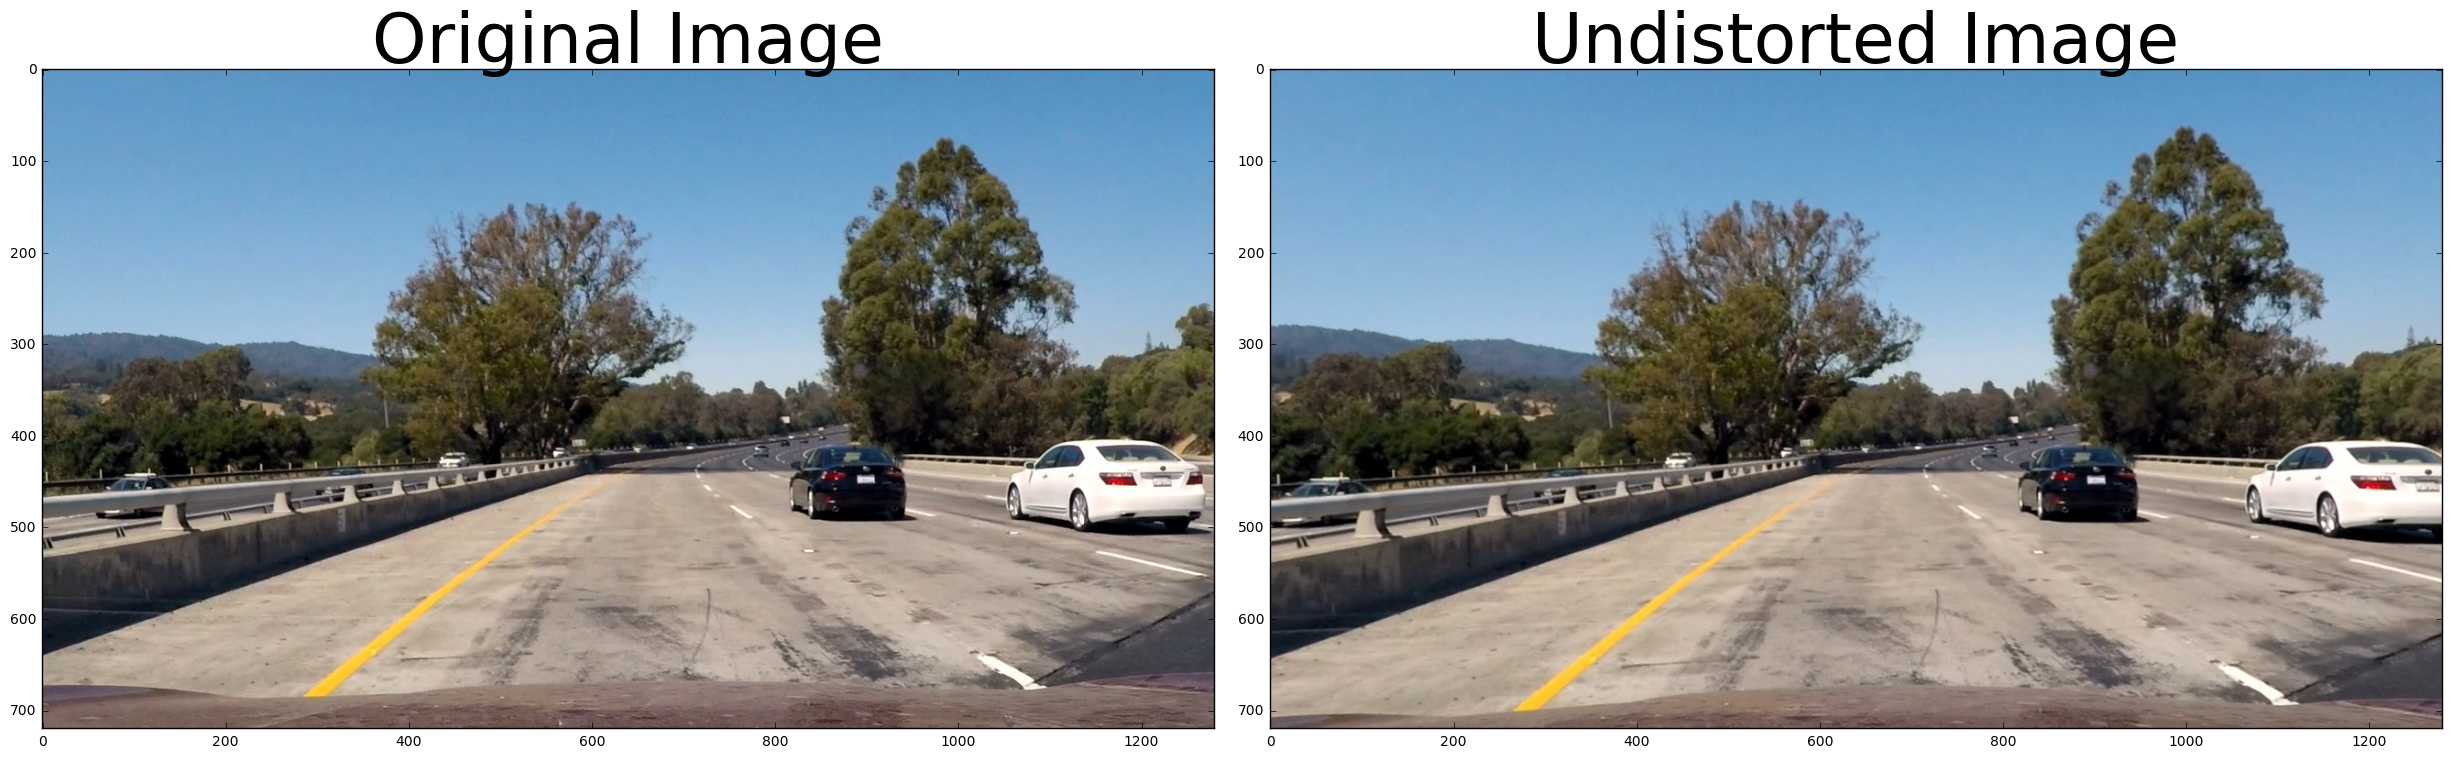

In [3]:
# Glob in the camera calibration images
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

'''Find object points'''
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

'''Find image points by cycling through the each of the calibration photos'''
for fname in images:
    # Read in each image
    img = mpimg.imread(fname)
    
    # Convert image file to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Take grayscale image and find the corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        #Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
'''Create a function to calibrate and undistort an image'''
def calibration_undistort(img, objpoints, imgpoints):
    # Graysclae the input image.
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Calibrate the camera using the object and imgpoints
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    #Undistort the original image using the camera matric and distortion coefficients
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Call Function on test image to see if it worked.
undist = calibration_undistort(test_ex_img, objpoints, imgpoints)


'''Display the original and undistorted images'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(example_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Part 2: Grayscale and Color Thresholds Functions

In [4]:
#def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), d_thresh=(0.7, 1.3), m_thresh=(30, 100)):

'''HLS S Channel Threshold'''
def hls_s_thresh(img, s_thresh=(90, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

'''HLS L Channel Threshold'''
def hls_l_thresh(img, l_thresh=(90, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    l_channel = hls[:,:,1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    return l_binary   

'''Absolute Value of Sobel X Threshold'''
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, abs_thresh=(20, 100 )):
    # Graysclae the image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply Sobel Operator
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # Get Absolute Value of Sobel
    abs_sobel = np.absolute(sobel)
    # Scale the absolute value output
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1   
    return sxbinary

'''Magnitude of the gradient - Kernal size 3'''    
def mag_thresh(img, sobel_kernel=3, m_thresh=(30, 100)):
    # Turn img to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    m_binary = np.zeros_like(gradmag)
    m_binary[(gradmag >= m_thresh[0]) & (gradmag <= m_thresh[1])] = 1
    return m_binary

'''Direction of the gradient - Kernal size 15'''
def dir_thresh(img, sobel_kernel=3, d_thresh=(0.7, 1.3)):   
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    d_binary =  np.zeros_like(graddir)
    d_binary[(graddir >= d_thresh[0]) & (graddir <= d_thresh[1])] = 1
    return d_binary


In [17]:
'''Create a function that creates an image mask'''
def image_mask(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    vertices = np.array([[(100,ysize), (600,400), (700,400), (xsize,ysize-40) ]] ,dtype = np.int32)
  
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Part 3: Perspective Transform Function

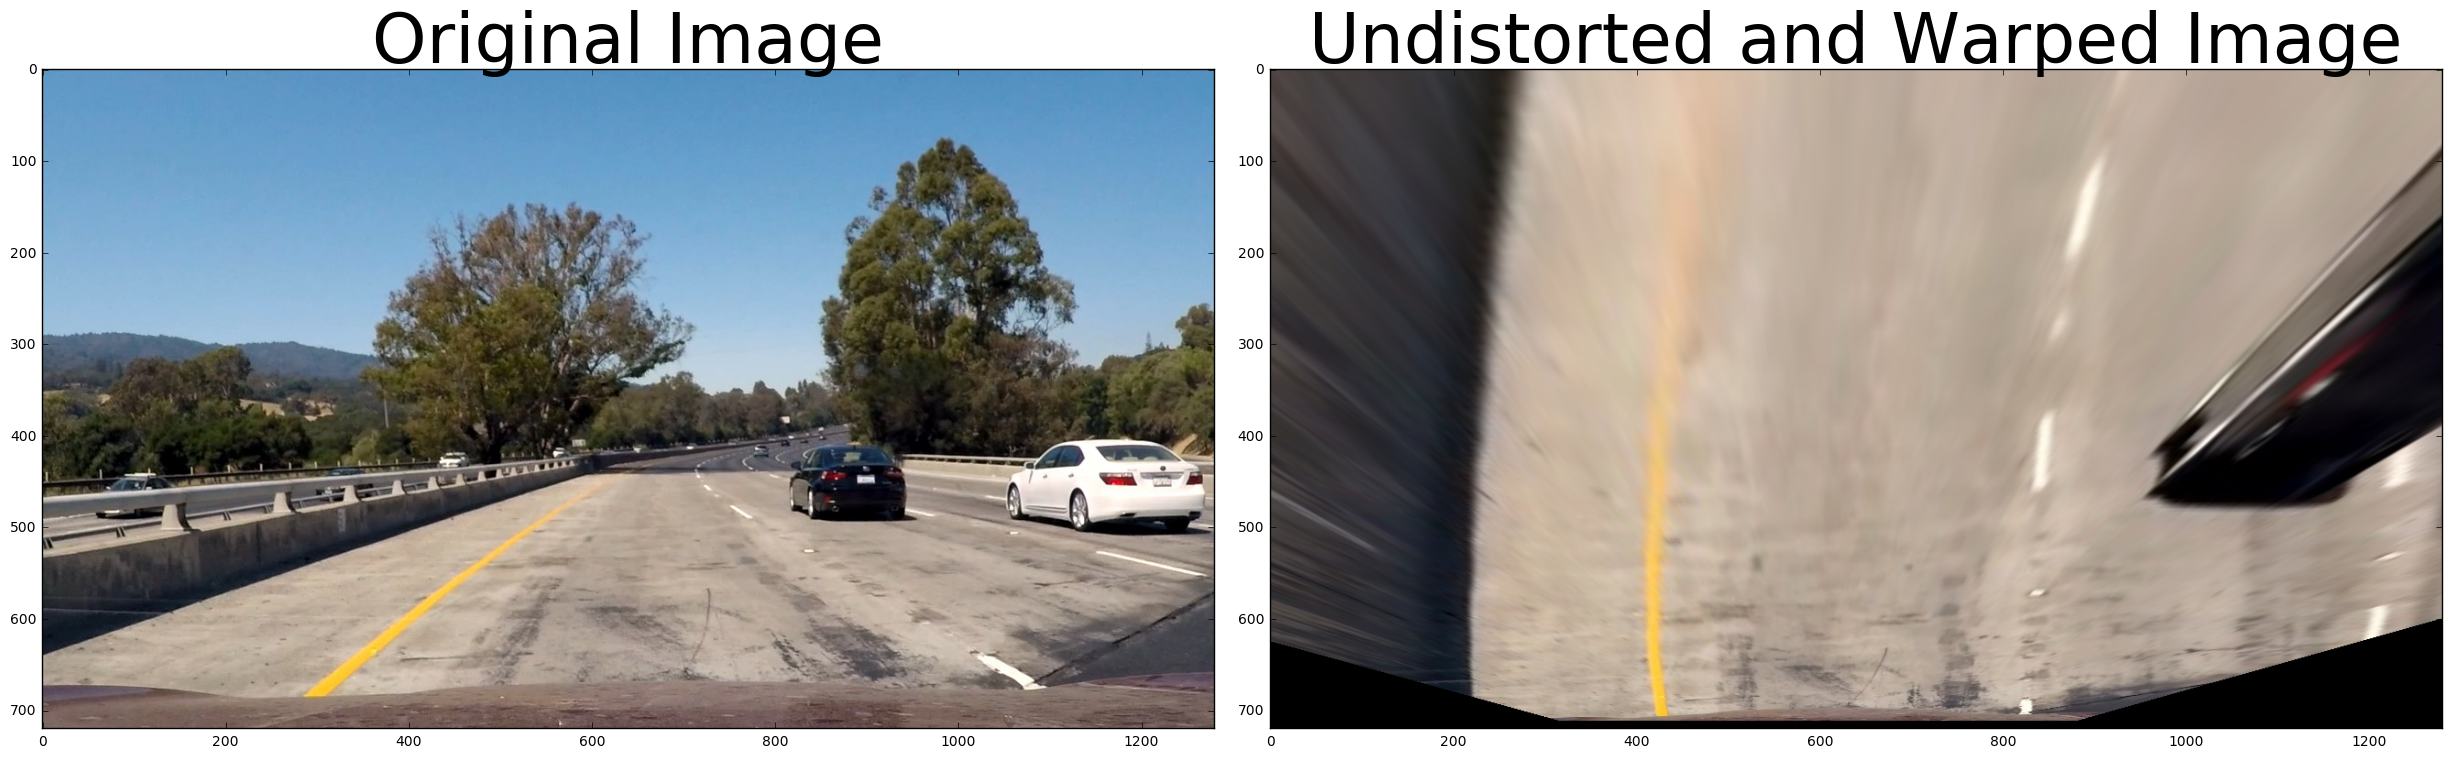

In [5]:
def perspective_transform(img):
     # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Define 4 source points src = np.float32([[,],[,],[,],[,]])
    src = np.float32([(600,450), (690,450), (250,680), (1040,680)])
    
    # c) Define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([(400, 0), (800, 0), (400, 700), (800, 700)])
    
    '''Do you use () or []? Also, do you put it into this order of corners?'''
    #src = np.float32([(570,460), (700,460), (250,680), (1050,680)])
    #dst = np.float32([(450,0), (w-450,0), (450,h),(w-450,h)])  
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix and the inverse transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  
    return warped, M, M_inv


warped, M_ex, M_inv_ex = perspective_transform(undist)

#top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(example_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Part 4: Sliding Window Function

In [6]:
def slidingwindow(img):    
    # Take a histogram of the bottom half of the image
    global left_fitx_prev, right_fitx_prev, left_fity_prev, right_fity_prev
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    output_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 45
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    '''Step through the windows one by one'''
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        # Identify left lane line
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        # Identify Right lane line
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        found_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        found_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append found indices to the lists
        left_lane_inds.append(found_left_inds)
        right_lane_inds.append(found_right_inds)
        # Recenter next window on their mean position if you found > minpix pixels
        if len(found_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(found_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Declare left and right line pixel positions from the indices
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    '''Fit a polynomial to the lane lines'''
    # Left Lane Line
    if len(leftx) != 0:  # To avoid non-empty vector for x
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx_prev = left_fit
        left_fity_prev = lefty
    else:
        left_fit = left_fitx_prev
        lefty = left_fity_prev
    # Right Lane Line
    if len(rightx) != 0: # To avoid non-empty vector for x
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx_prev = right_fit
        right_fity_prev = righty
    else:
        right_fit = right_fitx_prev
        righty = right_fity_prev
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]   
    return out_img, ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, histogram

def draw_lines(img, warped_img, ploty, left_fitx, right_fitx, M_inv):
    # Create an image to draw the lines on
    undist=img
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Return the output
    return result

# Part 5: Calculate Radius Curvature

In [16]:
'''Create function to output the radius curvature'''
def radius_curv(bin_img, ploty, leftx, rightx, lefty, righty):
    global left_curve_radius_prev, right_curve_radius_prev
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    if len(leftx)==0 or len(lefty)==0 or len(rightx)==0 or len(righty)==0:
        leftx = left_fitx_prev
        lefty = left_fity_prev
        rightx = right_fitx_prev
        righty = right_fity_prev
        return left_curve_radius_prev, right_curve_radius_prev
    else:    
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        if len(rightx)==0:    
            rightx = right_fit_prev
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        left_curve_radius_prev = left_curverad
        right_curve_radius_prev = right_curverad
    return left_curverad, right_curverad

'''Create a function to determine the distance from the center'''
def dist_from_center(histogram):
    xm_per_pix = 3.7/700
    midpoint = np.int(histogram.shape[0]/2)
    left_x_point = np.argmax(histogram[:midpoint])
    right_x_point = np.argmax(histogram[midpoint:]) + midpoint
    screen_off_center = midpoint - (int(left_x_point + right_x_point)/2)
    meters_off_center = xm_per_pix * screen_off_center
    return meters_off_center

'''Draw details of curvature on the image'''
def write_details(undist_img,lane_img, pos_off, rad):
    org_img = undist_img
    fin_img = lane_img    
    font = cv2.FONT_HERSHEY_PLAIN
    radius = "Radius of Curvature: {} m".format(int(rad))
    cv2.putText(fin_img,radius,(50,100), font, 1.8,(255,255,255),2)
    text = "{:.2f} m off center".format(pos_off)
    cv2.putText(fin_img,text,(50,160), font, 1.8,(255,255,255),2)  
    return fin_img

# Pert 6: Test All Thresholds and Create a Pipeline

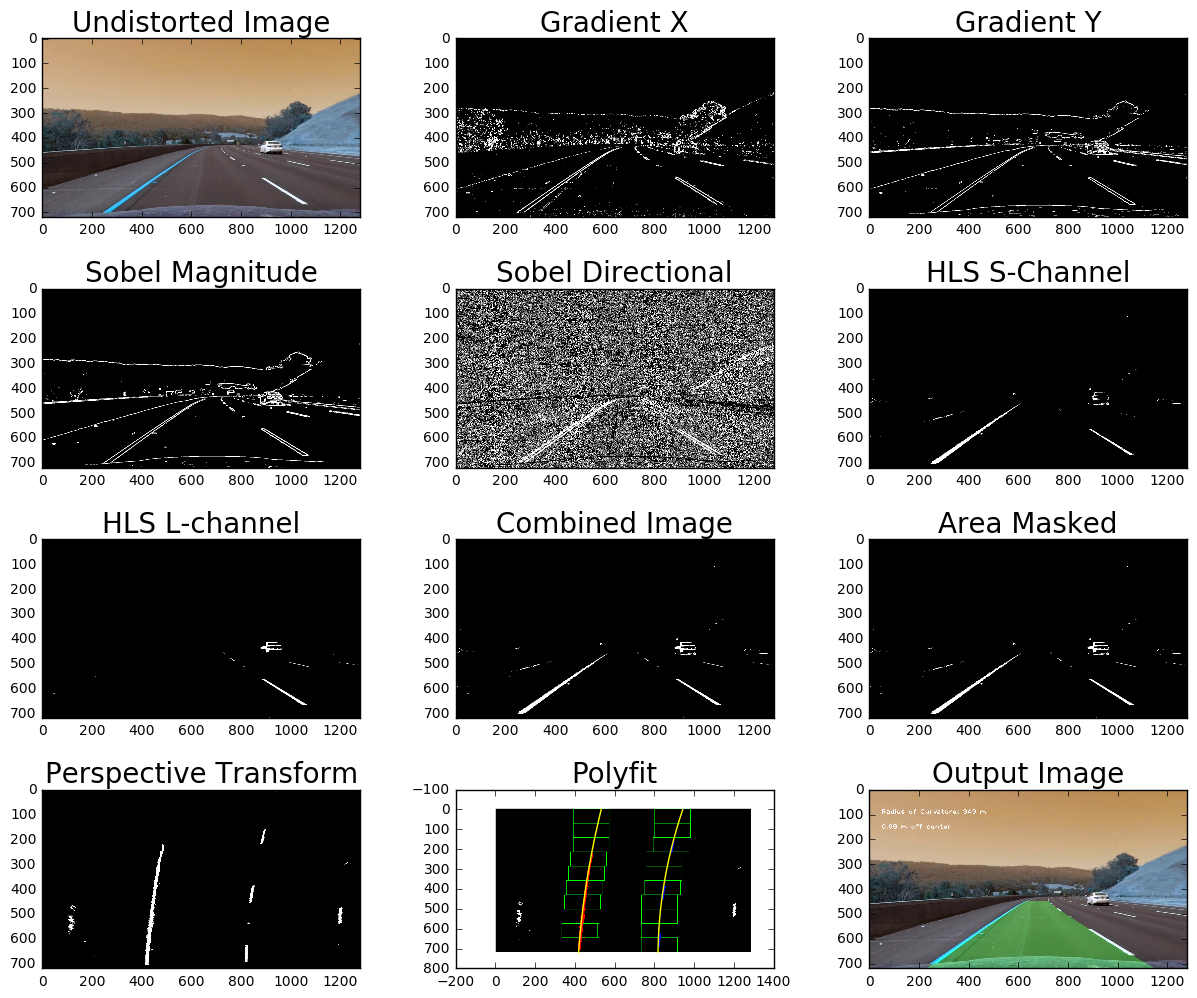

In [18]:
# Intial Pipeline To Test All Methods
def pipeline(img, ksize):  
    # Undistort image
    undistorted_test = calibration_undistort(img, objpoints, imgpoints)
    
    # Apply Sobel Operator   
    gradx = abs_sobel_thresh(undistorted_test, orient='x', sobel_kernel=ksize, abs_thresh=(15, 255))
    grady = abs_sobel_thresh(undistorted_test, orient='y', sobel_kernel=ksize, abs_thresh=(30, 255))

    # Apply Sobel Magnitude of Gradient
    mag_binary = mag_thresh(undistorted_test, sobel_kernel=ksize, m_thresh=(40, 255))
    
    # Apply Sobel Direction of Gradient
    dir_binary = dir_thresh(undistorted_test, sobel_kernel=ksize, d_thresh=(0.7, 1.3))

    # Apply HLS Color Channel S-Channel
    s_channel = hls_s_thresh(undistorted_test, s_thresh=(120, 255))
    
    # Apply HLS Color Channel L-Channel
    l_channel = hls_l_thresh(undistorted_test, l_thresh=(210, 255))
    
    # Combine L-Channel and S-Channel
    combined = np.zeros_like(l_channel)
    combined[(s_channel == 1) | (l_channel == 1)] = 1
    
    # Area of Interest Mask
    #area_img = region_of_interest(combined)
    
    # Perspective Transform
    binary_warped, perspective_M, M_inv = perspective_transform(combined)
    
    out_img, ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, histogram = slidingwindow(binary_warped)
    lane_img_test = draw_lines(undistorted_test, binary_warped, ploty, left_fitx, right_fitx, M_inv)
    left_curverad, right_curverad = radius_curv(binary_warped, ploty, leftx, rightx, lefty, righty)
    pos_off = dist_from_center(histogram)

    result_test = write_details(undistorted_test, lane_img_test, pos_off, (left_curverad + right_curverad)/2)
      
    
    fig, axs = plt.subplots(4,3, figsize=(16, 12))
    fig.subplots_adjust(hspace = .4, wspace=.001)
    axs = axs.ravel()
    axs[0].imshow(undistorted_test)
    axs[0].set_title('Undistorted Image', fontsize=20)
    axs[1].imshow(gradx, cmap='gray')
    axs[1].set_title('Gradient X', fontsize=20)
    axs[2].imshow(grady, cmap='gray')
    axs[2].set_title('Gradient Y', fontsize=20)
    axs[3].imshow(mag_binary, cmap='gray')
    axs[3].set_title('Sobel Magnitude', fontsize=20)
    axs[4].imshow(dir_binary, cmap='gray')
    axs[4].set_title('Sobel Directional', fontsize=20)
    axs[5].imshow(s_channel, cmap='gray')
    axs[5].set_title('HLS S-Channel', fontsize=20)
    axs[6].imshow(l_channel, cmap='gray')
    axs[6].set_title('HLS L-channel', fontsize=20)
    axs[7].imshow(combined, cmap='gray')
    axs[7].set_title('Combined Image', fontsize=20)
    axs[8].imshow(combined, cmap='gray')
    axs[8].set_title('Area Masked', fontsize=20)
    axs[9].imshow(binary_warped, cmap='gray')
    axs[9].set_title('Perspective Transform', fontsize=20)
    axs[10].imshow(out_img)
    axs[10].plot(left_fitx, ploty, color='yellow')
    axs[10].plot(right_fitx, ploty, color='yellow')
    axs[10].set_title('Polyfit', fontsize=20)
    axs[11].imshow(result_test)
    axs[11].set_title('Output Image', fontsize=20)
    
# Demo All Functions
ksize=5 # Setting Kernel Size
test_image = cv2.imread('./test_images/test3.jpg')
pipeline(test_image, ksize)

# Part 7: Create Pipeline For The Video

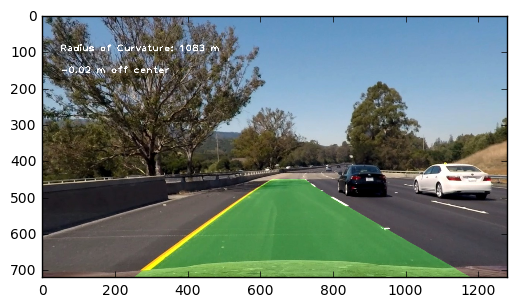

In [23]:
def video_pipeline(img, ksize):
            
    # Undistort image
    undistorted_test = calibration_undistort(img, objpoints, imgpoints)
    
    # HLS Color Channel S - Channel
    s_channel = hls_s_thresh(undistorted_test, s_thresh=(100, 255))
    
    # HLS Color Channel S - Channel
    l_channel = hls_l_thresh(undistorted_test, l_thresh=(200, 255))
    
    # Combine Mag gradient, S - Channel, and L - Channel
    combined_img = np.zeros_like(l_channel)
    combined_img[(s_channel == 1)  | (l_channel == 1)] = 1
     
    # Area of Interest Mask
    area_img = image_mask(combined_img)
    
    # Perspective Transform
    binary_warped, perspective_M, M_inv = perspective_transform(area_img)
    
    return undistorted_test, binary_warped, perspective_M, M_inv



def process_test():
    # Reading all images in /test_images folder
    images_test = glob.glob('./test_images/*.jpg')
    ksize=5 # Setting Kernel Size

    for fname1 in images_test:
        img_t = mpimg.imread(fname1)
        
        undist, bin_img, M, M_inverse = video_pipeline(img_t, ksize)    
        
        #Plot the Result
        out_img, ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist = slidingwindow(bin_img)
        lane_img = draw_lines(undist, bin_img, ploty, left_fitx, right_fitx, M_inverse)
        left_curverad, right_curverad = radius_curv(bin_img, ploty, leftx, rightx, lefty, righty)
        pos_off = dist_from_center(hist)

        result = write_details(undist, lane_img, pos_off, (left_curverad + right_curverad)/2)
        plt.imshow(result)
        
        
process_test()  # Run this method to test on all test images


# -->Dont forget to print and save an example in the output_images folder<--

# Part 8: Apply the pipeline to the video

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def video_process(img):
    global i, ploty_p, left_fitx_p, right_fitx_p, leftx_p, rightx_p, lefty_p, righty_p, hist_p
    global ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi
    img_t = img
    offset = 900
    undist, bin_img, M, M_inverse = video_pipeline(img_t, ksize)    
    #Plot the Result
    out, ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist = slidingwindow(bin_img)
    left_curverad, right_curverad = radius_curv(bin_img, ploty, leftx, rightx, lefty, righty)
    pos_off = dist_from_center(hist)
    
    if int((left_curverad + right_curverad)/2) > 800:
        ploty_p, left_fitx_p, right_fitx_p, leftx_p, rightx_p, lefty_p, righty_p, hist_p = ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist
        lane_img = draw_lines(undist, bin_img, ploty, left_fitx, right_fitx, M_inverse)
        result = write_details(undist, lane_img, pos_off, (left_curverad + right_curverad)/2) 
        #i = i+1
        #if (i-offset > 100):
            #ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi = ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist
    elif int((left_curverad + right_curverad)/2) < 800:
        #ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist = ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi
        lane_img = draw_lines(undist, bin_img, ploty, left_fitx, right_fitx, M_inverse)
        result = write_details(undist, lane_img, pos_off, (left_curverad + right_curverad)/2) 

    return result


# -->Dont forget to print and save an example in the output_images folder<--

In [27]:
yellow_output = 'project_output.mp4'
clip2 = VideoFileClip('project_video-Copy1.mp4', audio=False)
yellow_clip = clip2.fl_image(video_process)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [24:19<00:01,  1.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 30min 4s, sys: 26.4 s, total: 30min 31s
Wall time: 24min 21s
